## Exploratory data analysis

This notebook provides info about the distribution of the data collected as well as how it has been gathered.

### Raw data collection

The task to be performed requires a big corpus of Java source code and the choice made is to clone and compile a number 
of popular open source projects to perform static analysis and label source files as vulnerable or not.

The projects that have been analyzed are mostly from the Apache Software Foundation:

* [Atlas (1.2.0-rc3)](https://github.com/apache/atlas/releases/tag/release-1.2.0-rc3)
* [Calcite (1.18.0)](https://github.com/apache/calcite/releases/tag/calcite-1.18.0)
* [Camel (2.20.4)](https://github.com/apache/camel/tree/220d36e64b669bc1464a41a613f512e6bae23edb)
* [Dubbo (2.7.3)](https://github.com/apache/dubbo/releases/tag/dubbo-2.7.3)
* [Flink (1.9.0)](https://github.com/apache/flink/releases/tag/release-1.9.0)
* [Hadoop (3.1.1)](https://github.com/apache/hadoop/tree/2b9a8c1d3a2caf1e733d57f346af3ff0d5ba529c)
* [Hbase (2.1.6)](https://github.com/apache/hbase/releases/tag/rel%2F2.1.6)
* [Ignite (2.07.05)](https://github.com/apache/ignite/releases/tag/2.7.5)
* [Knox (0.3.0)](https://github.com/apache/knox/releases/tag/v0.3.0-final)
* [Maven (3.5.0)](https://github.com/apache/maven/tree/ff8f5e7444045639af65f6095c62210b5713f426)
* [Nifi (0.4.0)](https://github.com/apache/nifi/releases/tag/nifi-0.4.0)
* [Pulsar (2.4.1)](https://github.com/apache/pulsar/releases/tag/v2.4.1)
* [Ranger (2.0.0)](https://github.com/apache/ranger/releases/tag/release-ranger-2.0.0)
* [Rocketmq (4.3.0)](https://github.com/apache/rocketmq/releases/tag/rocketmq-all-4.3.0)
* [Storm (0.9.3)](https://github.com/apache/storm/releases/tag/v0.9.3)
* [Syncope (1.2.8)](https://github.com/apache/syncope/releases/tag/syncope-1.2.8)
* [Tika (1.0)](https://github.com/apache/tika/releases/tag/1.0)
* [Tomcat (8.05.01)](https://github.com/apache/tomcat/releases/tag/8.5.1)

Also intentionally vulnerable projects were taken into account:

* [bodgeit (1.4.0)](https://github.com/psiinon/bodgeit)
* [Webbank](https://github.com/pentestingforfunandprofit/webbank)
* [Webgoat](https://github.com/WebGoat/WebGoat)

### Source files labeling

Artifacts of all the projects were used to perform static analysis with SpotBugs and its plugin Find Security Bugs. As
the task is to work at file-level granularity, files are marked vulnerable if they presented at least a bug belonging to
correctness, multi-threaded correctness, malicious code, bad practice and security categories.

The choice of having the output of a static analyzer as ground truth (and so to avoid using public databases like the
NVD) derives from the results shown in previous works that highlight how models trained on synthetic source code perform
worse than those trained on SASTs output.

Although SpotBugs has been reported to output a relevant amount of false-positives (this behavior has been improved with
the latest releases), the results of this study are to be considered as a lower bound of the performance that a similar
model would achieve if trained on a hand-crafted dataset made by security experts.

### Dataset distribution

The data collected turned out not to be split equally between safe and vulnerable files.

In [1]:
import src.preparation.stats_extractor as stats_extractor

stats_extractor.__extract_stats()

The stats for every project analyzed are reported in the table below.

In [2]:
projects_stats = stats_extractor.count_project_files()

total = 0
weak = 0

print("{:12s} {:14s} {:15s}".format('Project','Total files','Weak files'))

for project in projects_stats.keys():
    total += projects_stats[project]["total_files"]
    weak += projects_stats[project]["weak_files"]
    print("{:12s} {:>11d} {:>13d}".format(project, projects_stats[project]["total_files"],
                                          projects_stats[project]["weak_files"]))

print("\n{:12s} {:>11d} {:>13d}".format("Total", total, weak))


Project      Total files    Weak files     
tomcat              1674           249
ranger               989             0
webgoat              300            79
maven                801            65
flink               5130            12
atlas                531            68
ignite              4961           513
storm                605           115
hadoop              5764           495
camel               8462           608
hbase               2181            93
rocketmq             610            89
webbank               16             3
tika                   8             0
pulsar              1274           218
calcite             1535           141
syncope             2097           285
bodgeit                5             4
dubbo                969           159
nifi                1843           229
knox                 390            20

Total              40145          3445


Overall the stats reported show the high unbalance between vulnerable and non-vulnerable files and this probably
suggests the need for undersampling when it comes to modeling.

More detailed info are reported by the pie charts that follow.

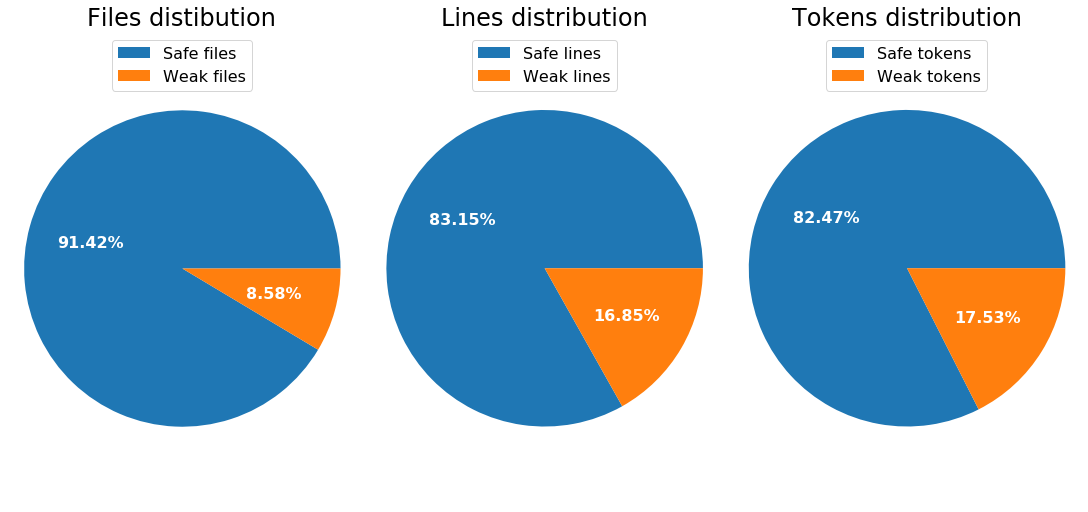

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

files_count = stats_extractor.count_files()
lines_count = stats_extractor.count_lines()
tokens_count = stats_extractor.count_tokens()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,7), constrained_layout=True)

wedges, texts, autotexts = ax[0].pie([files_count["safe"], files_count["weak"]], 
        autopct='%.2f%%', textprops=dict(color="w"))
ax[0].axis("equal")
ax[0].legend(["Safe files", "Weak files"], loc="upper center", fontsize=16)
plt.setp(autotexts, size=16, weight="bold")
ax[0].set_title("Files distibution", fontsize=24)

wedges, texts, autotexts = ax[1].pie([lines_count["safe"], lines_count["weak"]],
        autopct='%.2f%%', textprops=dict(color="w"))
ax[1].axis("equal")
ax[1].legend(["Safe lines", "Weak lines"], loc="upper center", fontsize=16)
plt.setp(autotexts, size=16, weight="bold")
ax[1].set_title("Lines distribution", fontsize=24)

wedges, texts, autotexts = ax[2].pie([tokens_count["safe"], tokens_count["weak"]],
        autopct='%.2f%%', textprops=dict(color="w"))
ax[2].axis("equal")
ax[2].legend(["Safe tokens", "Weak tokens"], loc="upper center", fontsize=16)
plt.setp(autotexts, size=16, weight="bold")
ax[2].set_title("Tokens distribution", fontsize=24)

plt.show()
